In [1]:
import os
import warnings
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import ot

import condo

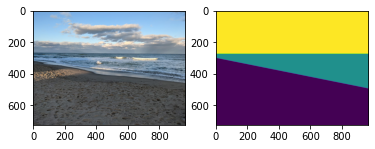

In [104]:
##############################################################################
# Load image data
# ---------------


def im2mat(img):
    """Converts and image to matrix (one pixel per line)"""
    return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))


def mat2im(X, shape):
    """Converts back a matrix to an image"""
    return X.reshape(shape)


def minmax(img):
    return np.clip(img, 0, 1)


# Loading images
this_file = os.path.realpath('__file__')
data_path = os.path.join(Path(this_file).parent.parent, 'data')

I1 = plt.imread(os.path.join(data_path, 'ocean_day.jpg')).astype(np.float64) / 256
I2 = plt.imread(os.path.join(data_path, 'ocean_sunset.jpg')).astype(np.float64) / 256
I3 = plt.imread(os.path.join(data_path, 'cape_cod.jpg')).astype(np.float64) / 256
I3L = I3[:, :500, :]
I3R = I3[:, 500:, :]

I1seg = I1.copy().astype(str)
I1seg[0:400, :, :] = 'sky'
I1seg[400:, :, :] = 'water'
I2seg = I2.copy().astype(str)
I2seg[0:500, :, :] = 'sky'
I2seg[500:, :, :] = 'water'

I3is, I3js = np.meshgrid(range(I3.shape[0]), range(I3.shape[1]), indexing='ij')
I3segshow = np.where(I3is - 300 < I3js/5, 1, 0)
I3segshow[0:275, :] += 1
I3seg = np.where(I3is - 300 < I3js/5, "water", "sand")
I3seg[0:275, :] = "sky"
fig, axes = plt.subplots(1, 2)
axes[0].imshow(I3)
axes[1].imshow(I3segshow)

I3Lseg = I3seg[:, :500]
I3Rseg = I3seg[:, 500:]

Y1 = im2mat(I1seg)[:, [0]]
Y2 = im2mat(I2seg)[:, [0]]
Y3 = im2mat(np.expand_dims(I3seg, 2))
Y3L = im2mat(np.expand_dims(I3Lseg, 2))
Y3R = im2mat(np.expand_dims(I3Rseg, 2))

X1 = im2mat(I1)
X2 = im2mat(I2)
X3 = im2mat(I3)
X3L = im2mat(I3L)
X3R = im2mat(I3R)

# Feature-Shift Only (Day to Sunset)

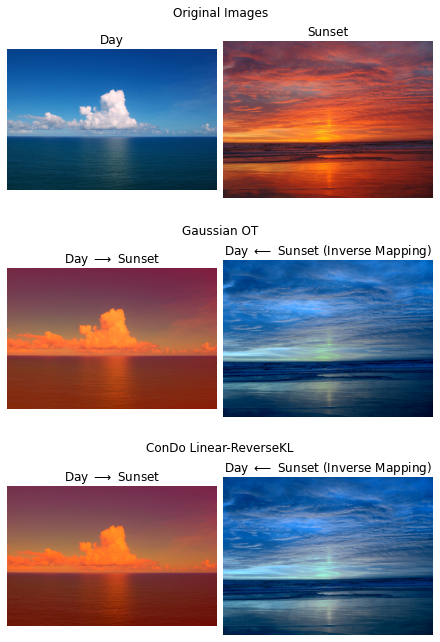

In [101]:
# Estimate mapping and adapt
mapping = ot.da.LinearTransport()
mapping.fit(Xs=X1, Xt=X2)
xst_otda = mapping.transform(Xs=X1)
xts_otda = mapping.inverse_transform(Xt=X2)
I1t_otda = minmax(mat2im(xst_otda, I1.shape))
I2t_otda = minmax(mat2im(xts_otda, I2.shape))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="affine",
        model_type="linear",
        divergence="reverse",
        debug=False,
        verbose=0
    )
cder.fit(X1, X2, Y1, Y2)
xst_linear = cder.transform(X1)
xts_linear = cder.inverse_transform(X2)
I1t_linear = minmax(mat2im(xst_linear, I1.shape))
I2t_linear = minmax(mat2im(xts_linear, I2.shape))

# Plot transformed images
fig = plt.figure(figsize=(6, 9), constrained_layout=True)

subfigs = fig.subfigures(nrows=3, ncols=1)
subfigs[0].suptitle('Original Images');
axes = subfigs[0].subplots(nrows=1, ncols=2)
axes[0].imshow(I1)
axes[0].axis('off')
axes[0].set_title('Day')
axes[1].imshow(I2)
axes[1].axis('off')
axes[1].set_title('Sunset');

subfigs[1].suptitle('Gaussian OT');
axes = subfigs[1].subplots(nrows=1, ncols=2)
axes[0].imshow(I1t_otda)
axes[0].axis('off')
axes[0].set_title('Day $\longrightarrow$ Sunset')
axes[1].imshow(I2t_otda)
axes[1].axis('off')
axes[1].set_title('Day $\longleftarrow$ Sunset (Inverse Mapping)')

subfigs[2].suptitle('ConDo Linear-ReverseKL');
axes = subfigs[2].subplots(nrows=1, ncols=2)
axes[0].imshow(I1t_linear)
axes[0].axis('off')
axes[0].set_title('Day $\longrightarrow$ Sunset')
axes[1].imshow(I2t_linear)
axes[1].axis('off')
axes[1].set_title('Day $\longleftarrow$ Sunset (Inverse Mapping)');

fig.savefig("DayToSunset.pdf", bbox_inches="tight")

# Confounded Shift (Day to Beach)

In [58]:
# Estimate mapping and adapt
mapping = ot.da.LinearTransport()
mapping.fit(Xs=X1, Xt=X3)
xst_otda = mapping.transform(Xs=X1)
xts_otda = mapping.inverse_transform(Xt=X3)
I1t_otda = minmax(mat2im(xst_otda, I1.shape))
I3t_otda = minmax(mat2im(xts_otda, I3.shape))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="affine",
        model_type="linear",
        divergence="reverse",
        debug=False,
        verbose=0
    )
cder.fit(X1, X3, Y1, Y3)
xst_linear = cder.transform(X1)
xts_linear = cder.inverse_transform(X3)
I1t_linear = minmax(mat2im(xst_linear, I1.shape))
I3t_linear = minmax(mat2im(xts_linear, I3.shape))

# Plot transformed images
fig = plt.figure(figsize=(6, 9), constrained_layout=True)

subfigs = fig.subfigures(nrows=3, ncols=1)
subfigs[0].suptitle('Original Images');
axes = subfigs[0].subplots(nrows=1, ncols=2)
axes[0].imshow(I1)
axes[0].axis('off')
axes[0].set_title('Day')
axes[1].imshow(I3)
axes[1].axis('off')
axes[1].set_title('Beach');

subfigs[1].suptitle('Gaussian OT');
axes = subfigs[1].subplots(nrows=1, ncols=2)
axes[0].imshow(I1t_otda)
axes[0].axis('off')
axes[0].set_title('Day $\longrightarrow$ Beach')
axes[1].imshow(I3t_otda)
axes[1].axis('off')
axes[1].set_title('Day $\longleftarrow$ Beach (Inverse Mapping)')

subfigs[2].suptitle('ConDo Linear-ReverseKL');
axes = subfigs[2].subplots(nrows=1, ncols=2)
axes[0].imshow(I1t_linear)
axes[0].axis('off')
axes[0].set_title('Day $\longrightarrow$ Beach')
axes[1].imshow(I3t_linear)
axes[1].axis('off')
axes[1].set_title('Day $\longleftarrow$ Beach (Inverse Mapping)');

fig.savefig("DayToBeach.pdf", bbox_inches="tight")

# Target Shift Only (Split Beach Photo)

In [110]:
# Estimate mapping and adapt
mapping = ot.da.LinearTransport()
mapping.fit(Xs=X3L, Xt=X3R)
xst_otda = mapping.transform(Xs=X3L)
xts_otda = mapping.inverse_transform(Xt=X3R)
I3Lt_otda = minmax(mat2im(xst_otda, I3L.shape))
I3Rt_otda = minmax(mat2im(xts_otda, I3R.shape))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="affine",
        model_type="linear",
        divergence="reverse",
        debug=False,
        verbose=0
    )
cder.fit(X3L, X3R, Y3L, Y3R)
xst_linear = cder.transform(X3L)
xts_linear = cder.inverse_transform(X3R)
I3Lt_linear = minmax(mat2im(xst_linear, I3L.shape))
I3Rt_linear = minmax(mat2im(xts_linear, I3R.shape))

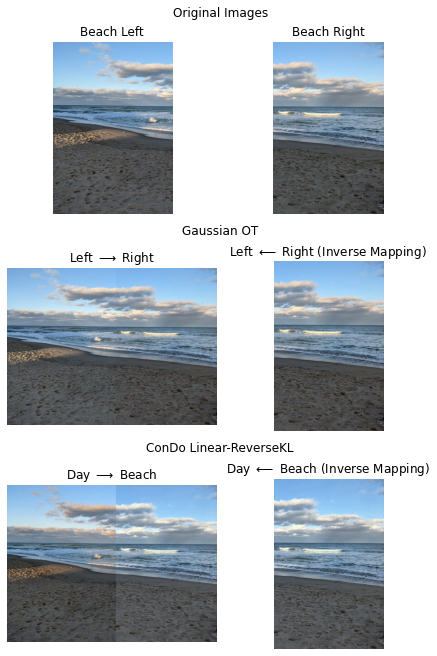

In [115]:
# Plot transformed images
fig = plt.figure(figsize=(6, 9), constrained_layout=True)

subfigs = fig.subfigures(nrows=3, ncols=1)
subfigs[0].suptitle('Original Images');
axes = subfigs[0].subplots(nrows=1, ncols=2)
axes[0].imshow(I3L)
axes[0].axis('off')
axes[0].set_title('Beach Left')
axes[1].imshow(I3R)
axes[1].axis('off')
axes[1].set_title('Beach Right');

subfigs[1].suptitle('Gaussian OT');
axes = subfigs[1].subplots(nrows=1, ncols=2)
axes[0].imshow(np.hstack([I3Lt_otda,I3Rt_otda]) )
axes[0].axis('off')
axes[0].set_title('Left $\longrightarrow$ Right')
axes[1].imshow(I3Rt_otda)
axes[1].axis('off')
axes[1].set_title('Left $\longleftarrow$ Right (Inverse Mapping)')

subfigs[2].suptitle('ConDo Linear-ReverseKL');
axes = subfigs[2].subplots(nrows=1, ncols=2)
axes[0].imshow(np.hstack([I3Lt_linear, I3Rt_linear]))
axes[0].axis('off')
axes[0].set_title('Day $\longrightarrow$ Beach')
axes[1].imshow(I3Rt_linear)
axes[1].axis('off')
axes[1].set_title('Day $\longleftarrow$ Beach (Inverse Mapping)');

fig.savefig("BeachLeftRight.pdf", bbox_inches="tight")

In [118]:
print((mapping.A_, mapping.B_))

(array([[0.98235021, 0.04401318, 0.00485284],
       [0.04401318, 0.93977112, 0.02484208],
       [0.00485284, 0.02484208, 0.96392422]]), array([[-0.0078673 ,  0.00502297,  0.01176685]]))


In [117]:
print((cder.M_, cder.b_))

(array([[-0.04513298,  1.67741474, -0.64974464],
       [-0.71275154,  1.87044936, -0.23479431],
       [-0.35572367,  0.17002608,  1.09744527]]), array([-0.02863589, -0.01218011, -0.013676  ]))
